# Model test: Weibull, simple linear predictor (V1)

In [2]:
import numpy as np
from scipy.stats import weibull_min # r weibull simulation
from scipy.stats import norm # for covariate simulation
from scipy.stats import gamma # for weibull shape parameter
from scipy.stats import bernoulli # for censoring
import pandas as pd

In [3]:
def random_rcensor(df,censor_prop,max_time):
    df = df.assign(
        y_censor = lambda dataframe: dataframe['y'].map(lambda y: min(np.random.uniform(high = max_time),y) if bernoulli.rvs(censor_prop) else min(y,max_time)),
        event = lambda dataframe: dataframe['y'] == dataframe['y_censor']
    )
    return(df)

def weibull_simple_linear_sim(n_beta,sigma,obs, censor_prop,max_time, show_beta = False):
    betas = norm.rvs(scale = sigma, size = n_beta) #generates the coefficients
    X = norm.rvs(size = obs*n_beta).reshape((obs,n_beta)) # matrix of covariates
    
    c = gamma.rvs(1) # shape parameter of weibull
    
    lin_pred = np.matmul(X,betas) # linear predictor
    
    sim_data = pd.DataFrame(X)
    sim_data["y"] = weibull_min.rvs(c, scale = np.exp(-lin_pred/c))
    
    if show_beta:
        print(betas)
        return(random_rcensor(sim_data,censor_prop,max_time))
    else:
        return(random_rcensor(sim_data,censor_prop,max_time))

In [4]:
cohort = weibull_simple_linear_sim(10,1,1000, 0.1 ,0.05, show_beta = True)
cohort

[-0.13105349  0.88817932  0.10210093  0.99610422  0.46494705  0.49107786
 -0.60135882  1.37503477  0.55135542 -0.30417624]


,0,1,2,3,4,5,6,7,8,9,y,y_censor,event
0,-0.638695,-0.056101,0.081473,0.236721,1.024469,0.702102,-1.660256,2.016416,0.123750,-0.496041,0.027510,0.027510,True
1,0.280420,-0.860896,-0.037021,2.148006,-0.985737,-1.775816,1.067725,1.167287,0.532267,0.018055,0.359295,0.041457,False
2,1.169883,-0.882430,-0.158195,-1.553652,0.724243,1.296601,0.603311,-0.075309,-0.788547,-0.850289,1.060264,0.050000,False
3,0.316675,-0.032775,1.212835,-0.598785,-0.945423,-0.137842,-0.542119,0.947963,-1.297217,-0.821573,0.729274,0.050000,False
4,1.080906,0.122388,0.651444,-0.910796,0.322515,0.509230,0.767174,0.342394,0.044447,-0.885749,1.312976,0.050000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.632188,-0.742635,0.617916,1.734574,-1.687658,-1.499328,-0.089816,-1.192075,2.316753,-0.466331,1.265158,0.050000,False
996,-0.566552,-1.322455,0.570584,-0.242440,-1.035234,-1.260473,-0.682632,1.332970,1.031282,1.244313,1.481303,0.050000,False
997,-2.042950,0.388598,-0.147589,-0.239780,0.806886,-0.336802,0.288200,0.564650,-2.675192,0.104247,0.503593,0.050000,False
998,-0.080390,-0.417188,-1.123598,0.562710,0.016567,-1.022638,1.311422,-0.092927,-1.056426,-1.167335,2.935841,0.050000,False


For now select a single case-subcohort:

In [5]:
cases = cohort[cohort.event]
subcohort = cohort.sample(frac = 0.2)

In [6]:
print(len(cases),len(subcohort))

62 200


In [7]:
subcohort[subcohort.event]

,0,1,2,3,4,5,6,7,8,9,y,y_censor,event
304,0.521841,-0.276088,-0.875291,0.068242,0.148293,0.312755,-1.083250,0.443611,-0.249110,-0.549078,0.033914,0.033914,True
551,-0.093329,0.735109,-0.253145,-0.648337,-0.711674,1.164704,-0.176995,0.692192,1.232050,-0.296538,0.020875,0.020875,True
226,-0.867539,0.577799,-0.752111,-0.417541,1.777570,0.761987,-1.206693,-0.035805,-1.284644,0.272525,0.037259,0.037259,True
846,2.516604,1.186627,-0.404485,1.368471,-0.056186,-2.550578,1.575431,1.962003,0.620033,0.120676,0.045546,0.045546,True
821,-0.324750,0.584604,1.340883,1.518091,1.073196,-1.029408,0.195059,1.237114,-0.398145,0.091891,0.031490,0.031490,True


We have very few cases in the cohort, so it makes sense to use a case-subcohort study. Note that in the subcohort there are only 3 events, so simply using a subset would have a low efficiency.

# Exploratory analysis 

In this section we ae just looking at some non-parametric plots to have some idea of what is going on.

In [8]:
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

Let us look at survival curves for the entire cohort:

Text(0.5, 0, 'time $t$')

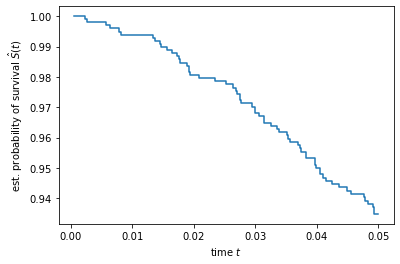

In [9]:
time, survival_prob = kaplan_meier_estimator(cohort['event'],cohort['y_censor'])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

Looking at each of the variables (descretising for ease of plotting):

In [10]:
cohort_discrete = np.floor(cohort[range(0,10)])
cohort_discrete

,0,1,2,3,4,5,6,7,8,9
0,-1.0,-1.0,0.0,0.0,1.0,0.0,-2.0,2.0,0.0,-1.0
1,0.0,-1.0,-1.0,2.0,-1.0,-2.0,1.0,1.0,0.0,0.0
2,1.0,-1.0,-1.0,-2.0,0.0,1.0,0.0,-1.0,-1.0,-1.0
3,0.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,0.0,-2.0,-1.0
4,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0
...,...,...,...,...,...,...,...,...,...,...
995,0.0,-1.0,0.0,1.0,-2.0,-2.0,-1.0,-2.0,2.0,-1.0
996,-1.0,-2.0,0.0,-1.0,-2.0,-2.0,-1.0,1.0,1.0,1.0
997,-3.0,0.0,-1.0,-1.0,0.0,-1.0,0.0,0.0,-3.0,0.0
998,-1.0,-1.0,-2.0,0.0,0.0,-2.0,1.0,-1.0,-2.0,-2.0


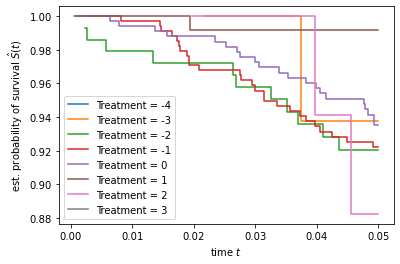

In [11]:
for i in range(-4,4):
    mask_treat = cohort_discrete[0] == i
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        cohort['event'][mask_treat],
        cohort['y_censor'][mask_treat])

    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="Treatment = %s" % i)

    
    
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

## Cox proportional hazards model

In [12]:
from sksurv.util import Surv

data_x = cohort[range(0,10)]
data_y = Surv().from_arrays(cohort['event'],cohort['y_censor'])

In [13]:
from sksurv.linear_model import CoxPHSurvivalAnalysis

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x, data_y)

CoxPHSurvivalAnalysis()

In [14]:
pd.Series(estimator.coef_, index = data_x.columns)

0   -0.162166
1    1.100555
2   -0.000275
3    0.925639
4    0.586104
5    0.505143
6   -0.592719
7    1.346680
8    0.578552
9   -0.340793
dtype: float64

We can see that the full cohort analysis is able to find the estimated variables ok. Now what happens if we use case-subcohort data? We can implement weightings here but probably need to use R for the normal treatment.

## Survival tree

In [112]:
from sklearn import tree

In [113]:
tr_clf = tree.DecisionTreeClassifier()

In [114]:
tr_clf = tr_clf.fit(test_sample.iloc[:,3:7],test_sample['chd'])

NameError: name 'test_sample' is not defined